# Optimal Denoising Schedule for Denoising Autoencoders
This notebook implements the optimal control framework for training a denoising autoencoder, as described in Section 3.3 of the paper *A statistical physics framework for optimal learning*.

It uses symbolic expressions and direct optimization (via CasADi) to identify optimal noise schedules that minimize the mean squared reconstruction error at the end of training.

## Imports
We import necessary libraries for numerical computation, symbolic optimization (CasADi), and visualization.

In [1]:
import numpy as np
import casadi
from casadi import *
import matplotlib.pyplot as plt
from numpy.random import normal
from tqdm import tqdm

## Helper Functions for Order Parameter Dynamics and MSE
These functions implement analytical expressions for the order parameter evolution and the mean squared error in the denoising autoencoder model. They correspond to the theoretical equations derived in Appendix A.3 of the paper.

In [2]:
#Define auxiliary functions for the ODEs

def lt_lt(Delta,sigma,Q,M,k,S,b):
    return (M[k,:].T@M[k,:])*(1-Delta)+((1-Delta)*sigma**2+Delta)*Q
    
def lt_lx(Delta,sigma,Q,M,k,S,b):
    return (M[k,:].T@M[k,:])*sqrt(1-Delta)+(sqrt(1-Delta)*sigma**2)*Q
    
def lx_lx(Delta,sigma,Q,M,k,S,b):
    return (M[k,:].T@M[k,:])+(sigma**2)*Q
    
def nut_nut(Delta,sigma,Q,M,k,S,b):
    stmp = reshape(S[k,:],K,1)
    return (stmp@stmp.T)*(1-Delta)+((1-Delta)*sigma**2+Delta)*S
    
def lt_nut(Delta,sigma,Q,M,k,S,b): #shape = r x K
    stmp= reshape(S[k,:],K,1)
    return (M[k,:].T@stmp.T)*(1-Delta)+((1-Delta)*sigma**2+Delta)*M.T
    
def lt_nux(Delta,sigma,Q,M,k,S,b):  #shape = r x K
    stmp= reshape(S[k,:],K,1)
    return (M[k,:].T@stmp.T)*sqrt(1-Delta)+(sqrt(1-Delta)*sigma**2)*M.T
    
def lx_nut(Delta,sigma,Q,M,k,S,b):  #shape = r x K
    stmp= reshape(S[k,:],K,1)
    return (M[k,:].T@stmp.T)*sqrt(1-Delta)+(sqrt(1-Delta)*sigma**2)*M.T
    
    
def lt_L(Delta,sigma,Q,M,k,S,b):
    r,_=Q.size()
    return lt_lx(Delta,sigma,Q,M,k,S,b)-lt_lt(Delta,sigma,Q,M,k,S,b)@(b*MX.eye(r)+Q)
        
def L_L(Delta,sigma,Q,M,k,S,b):
    r,_=Q.size()
    A=(b*MX.eye(r)+Q)@lt_lx(Delta,sigma,Q,M,k,S,b)
    return lx_lx(Delta,sigma,Q,M,k,S,b)-A-A.T+(b*MX.eye(r)+Q)@lt_lt(Delta,sigma,Q,M,k,S,b)@(b*MX.eye(r)+Q)

def x_x(Delta,sigma,Q,M,k,S,b):
    return sigma**2
def xt_xt(Delta,sigma,Q,M,k,S,b):
    return (1-Delta)*sigma**2+Delta
def x_xt(Delta,sigma,Q,M,k,S,b):
    return  sqrt(1-Delta)*sigma**2
    
def compute_mse(Delta,sigma,Q,M,S,b,cs,N):
    K=cs.size()[0]
    mse=MX(0)
    for k in range(K):
        mse+=cs[k]*(trace(Q@lt_lt(Delta,sigma,Q,M,k,S,b))\
            -2*trace(lt_lx(Delta,sigma,Q,M,k,S,b))+2*b*trace(lt_lt(Delta,sigma,Q,M,k,S,b))\
        +b**2*N*((1-Delta)*sigma**2+Delta)-2*b*N*sqrt(1-Delta)*sigma**2+N*sigma**2)
    return mse

## Model Parameters
Set the number of clusters, hidden nodes, and initialize symbolic variables for optimization.

In [3]:
K=2 #Number of Gaussian clusters (denoted C1 in the paper)
r=2 #Number of network hidden nodes (denoted K in the paper)

In [4]:
Delta = MX.sym('Delta',1)  #Noise level
sigma = MX.sym('sigma', 1)  #Variance of the Gaussian clusters
Q = MX.sym('Q', r, r)  #Student-student overlap
M = MX.sym('M', K, r)  #Student-centroid overlap (denoted R in the paper)
S = MX.sym('S', K, K)  #Centroid-centroid overlap dDenoted Omega in the paper)
b = MX.sym('b', 1)  #Skip connection
cs = MX.sym('cs', K) #Probability of cluster membership (p_c in the paper)
N = MX.sym('N', 1) #Input dimension
mse_sym = compute_mse(Delta, sigma, Q, M, S, b, cs, N)
mse_func = Function('mse_func', [Delta, sigma, Q, M, S, b, cs, N], [mse_sym])

In [5]:
np.random.seed(195)
N=1000
T=4 #scaled time T=\alpha_F \eta
mus=normal(0,1.,size=(K,N))/np.sqrt(N)
cs=DM.ones(K)/K
sigma=0.1
eta=5 #learning rate
b0=0.0 #initial condition for the skip connection
#Initializations
mutmp=np.concatenate((mus,mus),axis=0)
weights_0=0.2*mutmp[:r]+normal(0,1/np.sqrt(N),size=(r,N))
weights_0=np.array([weights_0[p]*np.sqrt(N)/np.linalg.norm(weights_0[p]) for p in range(r)])/2
M0=mus@weights_0.T/np.sqrt(N)
Q0=weights_0@weights_0.T/N
S=mus@mus.T

## ODEs 
Define the ODEs describing the training dynamics

In [6]:
O = MX.sym('O',r*(r+K)+1) #group dynamical variables
M, Q = O[:r*K], O[r*K:-1]
M = reshape(M, K, r)
Q = reshape(Q, r, r)
b = O[-1:]

In [7]:
#define the ODEs
dM=MX.zeros(K,r)
dQ=MX.zeros(r,r)
db=MX.zeros(1,1)
for k in range(K):
    dMtmp=eta*(lt_nux(Delta,sigma,Q,M,k,S,b).T-2*b*lt_nut(Delta,sigma,Q,M,k,S,b).T-M@lt_lt(Delta,sigma,Q,M,k,S,b)\
               +lx_nut(Delta,sigma,Q,M,k,S,b).T-lt_nut(Delta,sigma,Q,M,k,S,b).T@Q)

    dQtmp=(lt_L(Delta,sigma,Q,M,k,S,b)+lt_L(Delta,sigma,Q,M,k,S,b).T)*(2*eta+eta**2*(x_xt(Delta,sigma,Q,M,k,S,b)-b*xt_xt(Delta,sigma,Q,M,k,S,b)))\
            +eta**2*L_L(Delta,sigma,Q,M,k,S,b)*xt_xt(Delta,sigma,Q,M,k,S,b)\
            +eta**2*lt_lt(Delta,sigma,Q,M,k,S,b)*(x_x(Delta,sigma,Q,M,k,S,b)-2*b*x_xt(Delta,sigma,Q,M,k,S,b)+b**2*xt_xt(Delta,sigma,Q,M,k,S,b))  
    dM+=cs[k]*dMtmp
    dQ+=cs[k]*dQtmp
    db+=cs[k]*eta*(sqrt(1-Delta)*sigma**2-b*(1-Delta)*sigma**2-b*Delta)
    
dQ=0.5*(dQ+dQ.T)

# Scaling time with eta
dQ/=eta
dM/=eta
db/=eta

In [8]:
dM_flat = reshape(dM, K * r, 1)  # Column-major order (column by column)
dQ_flat = reshape(dQ, r * r, 1)  # Column-major order (column by column)

# Concatenate M_flat and Q_flat into a single vector
xdot = vertcat(dM_flat, dQ_flat, db)

## NLP 
Map the control problem into an NLP via a multiple-shooting method.

In [9]:
dT_control = 0.01
N_control = int(T//dT_control) # number of control intervals
L=MX(0)
alphas=np.linspace(0,T/eta,N_control+1)

In [10]:
dae = {'x':O, 'p':Delta, 'ode':xdot, 'quad':L}
F = integrator('F', 'cvodes', dae, 0, T/N_control)

In [11]:
# Define initial condition
Q0flat=Q0.flatten(order='F')
M0flat=M0.flatten(order='F')
O0=np.concatenate((M0flat, Q0flat,[b0])).tolist()

In [12]:
# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

In [13]:
# "Lift" initial conditions
Ok = MX.sym('O0', r*K+r*r+1)
w += [Ok]
lbw += O0
ubw += O0
w0 += O0
Delta0=0.01
Otmp=O0

In [14]:
# Formulate the NLP
for k in range(N_control):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k))
    w += [Uk]
    lbw += [0.01]
    ubw += [0.99]
    w0 += [Delta0]

    # Integrate till the end of the interval
    Fk = F(x0=Ok, p=Uk)
    Ok_end = Fk['xf']

    Otmp = F(x0=Otmp,p=Delta0)['xf']
    
    # New NLP variable for state at end of interval
    Ok = MX.sym('O_' + str(k+1), r*(r+K)+1)
    w   += [Ok]

    
    
    lbw +=  [0 if (K+r<=i and i<(K+r)*r) else -inf for i in range(r*(r+K)+1)]
    ubw += [inf for i in range(r*(r+K)+1)]
    w0 += Otmp.toarray().squeeze().tolist()

     # Add equality constraint
    g   += [Ok_end-Ok]
    lbg += [0 for i in range(r*(r+K)+1)]
    ubg += [0 for i in range(r*(r+K)+1)]



Mf, Qf = Ok[:r*K], Ok[r*K:-1]
Mf = reshape(Mf, K, r)
Qf = reshape(Qf, r, r)
bf=Ok[-1]

## Optimization 
Identify the optimal noise schedules for different values of the test noise $\Delta_F$

In [15]:
opt_list={"Deltaf":[], "M_opt":[], "Q_opt":[], "b_opt":[], "Delta_opt":[], "J_opt":[]}

In [16]:
const_list={"Deltaf":[], "M":[], "Q":[], "b":[], "J_const":[]}

In [17]:
Deltas=[0.1,0.3]

In [18]:
for Deltaf in Deltas:
    opt_list["Deltaf"].append(Deltaf)
    J=compute_mse(Deltaf,sigma,Qf,Mf,S,bf,cs,N)
    # Create an NLP solver
    prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', prob)
    # Solve the NLP
    print("\n\nSolving for $\\Delta_F=${}...\n\n".format(Deltaf))
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()

    #Optimal order parameters
    M_opt=[w_opt[i:i+K*r]for i in range(0, len(w_opt), K*r+r*r+2)]
    Q_opt=[w_opt[i:i+r*r]for i in range(K*r, len(w_opt), K*r+r*r+2)]
    b_opt=[w_opt[i]for i in range(K*(K+r), len(w_opt), K*r+r*r+2)]
    Delta_opt=[w_opt[i]for i in range(K*(K+r)+1, len(w_opt), K*r+r*r+2)]

    Jsopt=[]
    for i in range(len(b_opt)):
        Jsopt.append(mse_func(Deltaf,sigma,np.reshape(Q_opt[i],(r,r),order='F'),np.reshape(M_opt[i],(K,r),order='F'),S,b_opt[i],cs,N).full()[0][0])

    opt_list["M_opt"].append(M_opt)
    opt_list["Q_opt"].append(Q_opt)
    opt_list["b_opt"].append(b_opt)
    opt_list["Delta_opt"].append(Delta_opt)
    opt_list["J_opt"].append(Jsopt)



Solving for $\Delta_F=$0.1...



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    36236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    21927

Total number of variables............................:     3990
                     variables with only lower bounds:     1596
                variables with lower and upper bounds:      399
                     variables with only upper bounds:        0
Total number of equality constraints.................:    

## Constant noise schedules 
Evaluate the performance of the constant-noise schedule $\Delta=\Delta_F$

In [19]:
for Deltaf in Deltas:
    O0=np.concatenate((M0flat, Q0flat,[b0])).tolist()
    Ms=[M0flat]
    Qs=[Q0flat]
    bs=[b0]
    J_const=[float(compute_mse(Deltaf,sigma,reshape(Qs[-1], r, r),reshape(Ms[-1], K, r),S,bs[-1],cs,N))]
    
    O_variable=np.concatenate((M0flat, Q0flat,[b0])).tolist()
    
    for j in range(N_control):
        Fk = F(x0=O_variable,p=Deltaf)
        O_variable=Fk['xf']
        M_append=np.array(O_variable[:r*K])
        Ms.append([o[0] for o in M_append])
        Q_append=np.array(O_variable[r*K:-1])
        Qs.append([o[0] for o in Q_append])
        bs.append(float(O_variable[-1]))
        J_const.append(float(compute_mse(Deltaf,sigma,reshape(Qs[-1], r, r),reshape(Ms[-1], K, r),S,bs[-1],cs,N)))
    
    const_list["J_const"].append(J_const)
    const_list["M"].append(Ms)
    const_list["Q"].append(Qs)
    const_list["b"].append(bs)
    const_list["Deltaf"].append(Deltaf)

## Plotting the Optimal Schedule
We visualize the MSE obtained for the constant and optimal training schedules.

In [20]:
colors = [
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#009E73",  # green
    # "#F0E442",  # yellow
    "#D55E00",  # red/orange (vermillion)
    "#CC79A7",  # pink/purple
    "#999999",  # grey (neutral tone)
    "navy"
]
markers=['o','X','s','D','^','<','v']

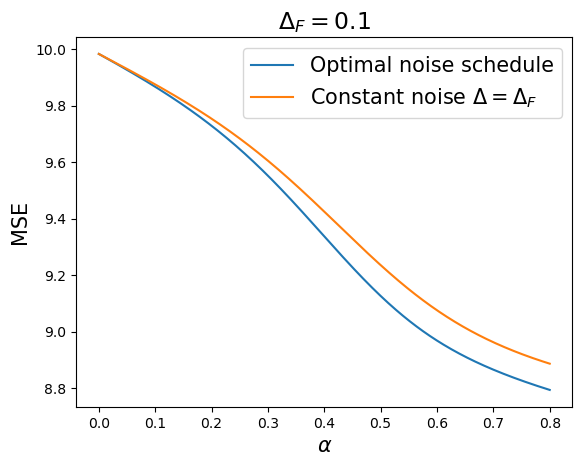

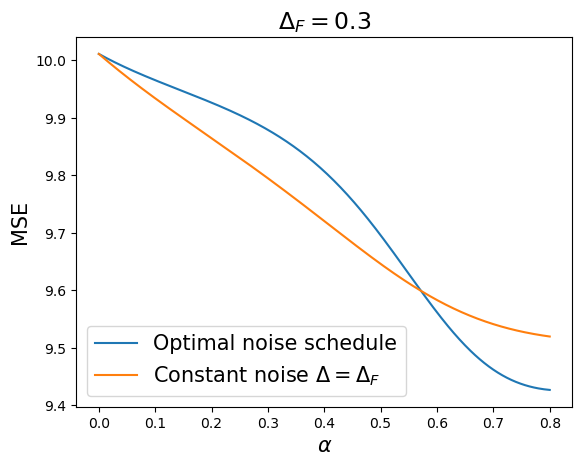

In [21]:
i=0
for Deltaf in Deltas:
    plt.figure(i)
    indices = [i for i, df in enumerate(opt_list["Deltaf"]) if df == Deltaf]
    J_opt_values = [opt_list["J_opt"][i] for i in indices]
    J_const_values = [const_list["J_const"][i] for i in indices]
    plt.plot(alphas,J_opt_values[0],label="Optimal noise schedule")
    plt.plot(alphas,J_const_values[0],label="Constant noise $\\Delta=\\Delta_F$")
    plt.title("$\\Delta_F=${}".format(Deltaf),fontsize=17)
    
    plt.legend(fontsize=15)
    plt.xlabel("$\\alpha$",fontsize=15)
    plt.ylabel("MSE",fontsize=15)
    i+=1